#### Get Filtered dataframe of All students and Year 2022:

In [1]:
import pandas as pd

# Load the Excel file
file_path = 'ap_performance_cleaned.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Filter rows based on conditions
filtered_df = df[(df['Student Group'] == 'All Students') & (df['Year'] == 2022)]

print(filtered_df)


                                          District Name  District Code  \
1411                                           Abington          10000   
1412                                   Acton-Boxborough        6000000   
1413  Advanced Math and Science Academy Charter (Dis...        4300000   
1414                                            Andover          90000   
1415                                          Arlington         100000   
...                                                 ...            ...   
1558                                         Winchester        3440000   
1559                                           Winthrop        3460000   
1560                                             Woburn        3470000   
1561                                          Worcester        3480000   
1562                                       State Totals              0   

      Tests Taken  Score=1  Score=2  Score=3  Score=4  Score=5  % Score 1-2  \
1411            6      NaN      

#### Get each district's Average Score

In [2]:
# Calculate the mean score for every district
def get_mean_score(filtered_df):
    district_avg_scores = {}
    for index, row in filtered_df.iterrows():
        score_sum = 0
        count = 0
        
        for i in range(1, 6):
            if not pd.isnull(row[f'Score={i}']):
                score_sum += i * row[f'Score={i}']
                count += row[f'Score={i}']
                
        # If there are available scores, get the mean score of the district
        if count != 0:
            district_avg_scores[row['District Name']] = score_sum / count
            
    return district_avg_scores

# Calculate the mean score for every district
district_avg_scores = get_mean_score(filtered_df)

# Create a new dataframe with the calculated average scores
result_df = pd.DataFrame(list(district_avg_scores.items()), columns=['District Name', 'Average Score'])

# Print the resulting dataframe
print(result_df)

                                        District Name  Average Score
0                                    Acton-Boxborough       4.474359
1   Advanced Math and Science Academy Charter (Dis...       4.000000
2                                             Andover       4.142857
3                                           Arlington       4.090909
4                                             Bedford       3.476190
..                                                ...            ...
65                                           Weymouth       1.600000
66                                         Winchester       3.826087
67                                             Woburn       2.176471
68                                          Worcester       2.222222
69                                       State Totals       3.321961

[70 rows x 2 columns]


#### Plot the Density Map of Masachusetts

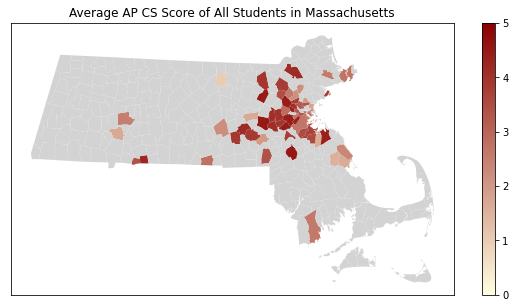

In [12]:

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

# Load your Shapefile with the polygons of the year 2000
gdf = gpd.read_file('MA_town_data/TOWNSSURVEY_POLYM_GENCOAST.shp') ## gdf is Geographical Data File

# Merge the GeoDataFrame and the pandas DataFrame on the "TOWN" column
merged = gdf.merge(result_df, left_on='TOWN', right_on='District Name', how='left')

# Define a color map for color mapping
cmap = LinearSegmentedColormap.from_list('mycmap', ['lightyellow', 'darkred'])


# Create a plot with custom styling
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Specify the color for missing data (grey in this case)
missing_color = 'lightgray'

# Plot the GeoDataFrame with color mapping and specify missing data color
merged.plot(
    column='Average Score',
    cmap=cmap,
    missing_kwds={'color': missing_color},
    vmin=0,
    vmax=5,
    ax=ax,
    legend=True
)

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Customize the plot (e.g., add a title)
ax.set_title('Average AP CS Score of All Students in Massachusetts')

# Show the plot
plt.show()


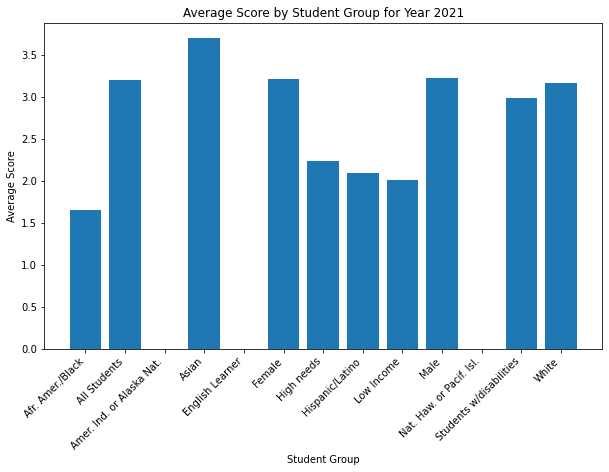

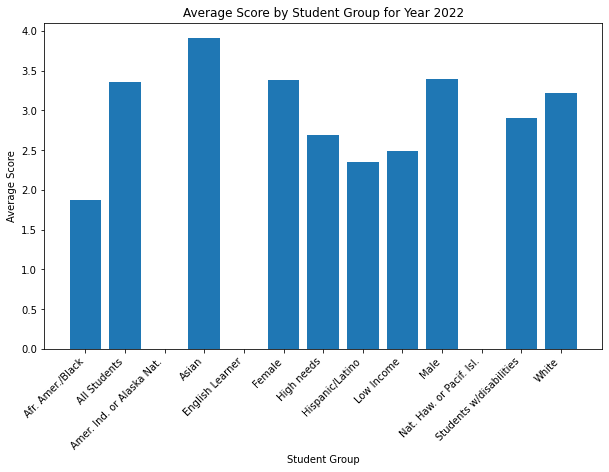

In [6]:
import numpy as np
import pandas as pd

# Load the Excel file
file_path = 'ap_performance_cleaned.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Group the DataFrame by 'Year' and 'Student Group' and sum the columns
df_grouped = df.groupby(['Year', 'Student Group']).sum().reset_index()

# Calculate the weighted average score for each group and year
score_columns = ['Score=1', 'Score=2', 'Score=3', 'Score=4', 'Score=5']
numerator = np.sum(df_grouped[score_columns] * np.array([1, 2, 3, 4, 5]), axis=1)
denominator = np.sum(df_grouped[score_columns], axis=1)
df_grouped['Weighted Avg Score'] = np.where(denominator > 0, numerator / denominator, np.nan)

# Iterate through each year and create a separate plot
years = df_grouped['Year'].unique()

for year in years:
    year_data = df_grouped[df_grouped['Year'] == year]
    student_groups = year_data['Student Group']
    average_scores = year_data['Weighted Avg Score']

    # Create a bar plot for the current year
    plt.figure(figsize=(10, 6))
    plt.bar(student_groups, average_scores)
    plt.title(f'Average Score by Student Group for Year {year}')
    plt.xlabel('Student Group')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45, ha='right')

    plt.show()
